**Proyek Mandiri LSTM**

Import library

In [1]:
import numpy as np
import pandas as pd 
from google.colab import drive

from matplotlib import pyplot as plt
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.metrics import mean_squared_error
from math import sqrt



In [2]:
# pip install EMD-signal

Load Dataset

In [3]:
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [4]:
path_train_dataset = 'gdrive/My Drive/S2/PML/proyek_mandiri/ABBV_train.csv'
df_train = pd.read_csv(path_train_dataset)
df = pd.read_csv(path_train_dataset)
# df_train = df_train[['open','high','low']]
df_train = df_train[['close']]


In [5]:
df.corr(method='pearson')

,open,high,low,close,volume
open,1.000000,0.997513,0.996577,0.994560,0.144509
high,0.997513,1.000000,0.995727,0.997500,0.167655
low,0.996577,0.995727,1.000000,0.997142,0.123946
close,0.994560,0.997500,0.997142,1.000000,0.147390
volume,0.144509,0.167655,0.123946,0.147390,1.000000


In [6]:
# df_train.tail()
df_train_target = df[['close']]

In [7]:
#load test set
path_test_dataset = 'gdrive/My Drive/S2/PML/proyek_mandiri/ABBV_test.csv'
df_test = pd.read_csv(path_test_dataset)
test_valid = df_test[['close']]
df_test_save = df_test
# df_test.head()
# df_test = df_test[['open','high','low']]
df_test = df_test[['close']]

In [8]:
df

,date,open,high,low,close,volume,Name
0,2013-02-08,36.370,36.420,35.825,36.25,13858795,ABBV
1,2013-02-11,36.130,36.180,35.750,35.85,6031957,ABBV
2,2013-02-12,35.770,35.900,35.200,35.42,7473991,ABBV
3,2013-02-13,35.420,35.570,35.150,35.27,4860053,ABBV
4,2013-02-14,35.050,36.730,35.010,36.57,7570052,ABBV
...,...,...,...,...,...,...,...
977,2016-12-23,61.780,62.395,61.470,62.34,4798112,ABBV
978,2016-12-27,62.520,63.015,62.410,62.50,5396206,ABBV
979,2016-12-28,62.510,62.750,62.250,62.27,5190362,ABBV
980,2016-12-29,62.390,63.060,62.390,62.73,4990040,ABBV


In [9]:
df_test_save 

,date,open,high,low,close,volume,Name
0,2017-01-03,62.920,63.0300,61.935,62.41,9328198,ABBV
1,2017-01-04,62.640,63.7999,62.640,63.29,8674823,ABBV
2,2017-01-05,63.380,63.9500,63.030,63.77,5359393,ABBV
3,2017-01-06,63.881,64.0000,63.520,63.79,4722267,ABBV
4,2017-01-09,63.800,64.3800,63.750,64.21,8794509,ABBV
...,...,...,...,...,...,...,...
272,2018-02-01,112.240,117.5300,112.230,116.34,9943452,ABBV
273,2018-02-02,115.500,117.9300,114.920,115.17,7184413,ABBV
274,2018-02-05,113.000,115.5350,109.400,109.51,9827825,ABBV
275,2018-02-06,104.910,113.5200,101.000,111.20,14107829,ABBV


In [10]:
df_train

,close
0,36.25
1,35.85
2,35.42
3,35.27
4,36.57
...,...
977,62.34
978,62.50
979,62.27
980,62.73


Preprocessing

In [11]:
#preproceesing training data
add = df_train[-7:]
test_data = add
test_data.reset_index()

test_data = test_data.append(df_test)
test_data

,close
975,61.45
976,61.66
977,62.34
978,62.50
979,62.27
...,...
272,116.34
273,115.17
274,109.51
275,111.20


In [12]:
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
Xscaler.fit(df_train)
scaled_X_train = Xscaler.transform(df_train)


In [ ]:
scaled_X_train

In [14]:
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(df_train_target)
scaled_y_train = Yscaler.transform(df_train_target)
print(scaled_y_train.shape)
scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)
print(scaled_y_train.shape)
 
scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

(982, 1)
(982,)


In [ ]:
scaled_y_train

In [16]:
n_input = 7 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= df_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
#b_size = 64
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
 
print(generator[0][0].shape)

(32, 7, 1)


In [17]:
print(df_train.shape)

(982, 1)


Arsitektur LSTM

In [18]:
regressor = Sequential()
regressor.add(LSTM(units = 100, activation='relu',return_sequences = True, input_shape = (n_input, n_features)))
regressor.add(LSTM(units = 100,activation='relu'))
regressor.add(Dense(units = 1))
opt = keras.optimizers.Adam(learning_rate=0.001)
regressor.compile(optimizer=opt, loss='mse')
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [19]:
#  regressor.fit_generator(generator,epochs=40)
regressor.fit_generator(generator,epochs=40)
 # test 1 epoch 40
 # test 2 epoch 60

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


31/31 [==============================] - 24s 13ms/step - loss: 0.2629
Epoch 2/40
31/31 [==============================] - 0s 12ms/step - loss: 0.0191
Epoch 3/40
31/31 [==============================] - 0s 14ms/step - loss: 0.0067
Epoch 4/40
31/31 [==============================] - 0s 13ms/step - loss: 0.0021
Epoch 5/40
31/31 [==============================] - 0s 13ms/step - loss: 0.0025
Epoch 6/40
31/31 [==============================] - 0s 13ms/step - loss: 0.0018
Epoch 7/40
31/31 [==============================] - 0s 13ms/step - loss: 0.0016
Epoch 8/40
31/31 [==============================] - 0s 13ms/step - loss: 0.0015
Epoch 9/40
31/31 [==============================] - 0s 13ms/step - loss: 0.0018
Epoch 10/40
31/31 [==============================] - 0s 13ms/step - loss: 0.0017
Epoch 11/40
31/31 [==============================] - 0s 13ms/step - loss: 0.0016
Epoch 12/40
31/31 [==============================] - 0s 13ms/step - loss: 0.0015
Epoch 13/40
31/31 [============================

In [20]:
scaled_X_test = Xscaler.transform(test_data)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(test_data)), length=n_input, batch_size=b_size)
# print(test_generator[0][0].shape)

In [21]:
y_pred_scaled = regressor.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)

In [22]:
y_pred

array([[ 62.911182],
       [ 62.8699  ],
       [ 63.097145],
       [ 63.658443],
       [ 64.05798 ],
       [ 64.30075 ],
       [ 64.406815],
       [ 63.209064],
       [ 61.762955],
       [ 61.458893],
       [ 61.98906 ],
       [ 62.16923 ],
       [ 61.922234],
       [ 61.622448],
       [ 61.39462 ],
       [ 61.133533],
       [ 61.236355],
       [ 61.514362],
       [ 61.162613],
       [ 60.659008],
       [ 60.81889 ],
       [ 61.250294],
       [ 61.29605 ],
       [ 61.137344],
       [ 61.00175 ],
       [ 60.92373 ],
       [ 60.876987],
       [ 60.965275],
       [ 60.9602  ],
       [ 60.852962],
       [ 60.918354],
       [ 61.414818],
       [ 61.797844],
       [ 61.973923],
       [ 62.056713],
       [ 61.951942],
       [ 61.96025 ],
       [ 62.215355],
       [ 62.45465 ],
       [ 62.383064],
       [ 62.60092 ],
       [ 63.140934],
       [ 63.574535],
       [ 63.747414],
       [ 63.88528 ],
       [ 64.15429 ],
       [ 64.542366],
       [ 65.3

In [23]:
print(type(y_pred))

<class 'numpy.ndarray'>


In [24]:
print(test_valid)

      close
0     62.41
1     63.29
2     63.77
3     63.79
4     64.21
..      ...
272  116.34
273  115.17
274  109.51
275  111.20
276  113.62

[277 rows x 1 columns]


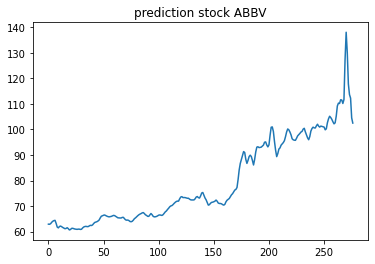

In [25]:
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.title('prediction stock ABBV')
plt.show()

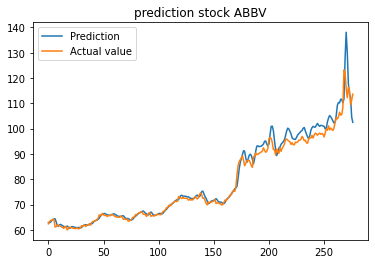

In [26]:
import matplotlib.pyplot as plt

plt.plot(y_pred, label = "Prediction")

# plotting the line 2 points 
plt.plot(test_valid, label = "Actual value")
# plt.xlabel('x - axis')
# Set the y axis label of the current axis.
# plt.ylabel('y - axis')
# Set a title of the current axes.
plt.title('prediction stock ABBV')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [27]:
# loss = keras.losses.mean_squared_error(test_valid, y_pred)
mse = mean_squared_error(test_valid, y_pred)
rmse = sqrt(mse)

In [28]:
print("mse = ",mse)
print("rmse = ",rmse)

mse =  8.35213197495608
rmse =  2.8900055319940274
